In [ ]:
!pip install -r requirements.txt

In [1]:
import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob

In [2]:
import torch
from torch import nn

In [3]:

from IPython.display import Image, HTML, clear_output
import tqdm


In [5]:
from model import CellT, CellGrowingCA, Cell, GrowingCA

In [6]:
def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))

def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

In [7]:
class VideoWriter:
  def __init__(self, filename, fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()

In [8]:
#@title Cellular Automata Parameters
CHANNEL_N = 16        # Number of CA state channels
TARGET_PADDING = 16   # Number of pixels used to pad the target image border
TARGET_SIZE = 40
BATCH_SIZE = 8
POOL_SIZE = 1024
CELL_FIRE_RATE = 0.5

TARGET_EMOJI = "🦎" #@param {type:"string"}

EXPERIMENT_TYPE = "Growing" #@param ["Growing", "Persistent", "Regenerating"]
EXPERIMENT_MAP = {"Growing":0, "Persistent":1, "Regenerating":2}
EXPERIMENT_N = EXPERIMENT_MAP[EXPERIMENT_TYPE]

USE_PATTERN_POOL = [0, 1, 1][EXPERIMENT_N]
DAMAGE_N = [0, 0, 3][EXPERIMENT_N]  # Number of patterns to damage in a batch

In [9]:

def load_image(url, max_size=TARGET_SIZE):
  r = requests.get(url)
  img = PIL.Image.open(io.BytesIO(r.content))
  img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  img = np.float32(img)/255.0
  # premultiply RGB by Alpha
  img[..., :3] *= img[..., 3:]
  return img

def load_emoji(emoji):
  code = hex(ord(emoji))[2:].lower()
  url = 'https://github.com/googlefonts/noto-emoji/raw/master/png/128/emoji_u%s.png'%code
  return load_image(url)

def to_rgba(x):
  return x[:,:4,:,:]

def to_alpha(x):
  return torch.clamp(x[:, 3:4, :, :], min=0.0, max=1.0)
  # return tf.clip_by_value(x[..., 3:4], 0.0, 1.0)

def to_rgb(x):
  # assume rgb premultiplied by alpha
  rgb, a = x[:, :3, :, :], to_alpha(x)
  return 1.0-a+rgb

def make_seed(size, n=1):
  x = np.zeros([n, size, size, CHANNEL_N], np.float32)
  x[:, size//2, size//2, 3:] = 1.0
  return x

In [10]:
#@title Train Utilities (SamplePool, Damage)
class SamplePool:
  def __init__(self, *, _parent=None, _parent_idx=None, **slots):
    self._parent = _parent
    self._parent_idx = _parent_idx
    self._slot_names = slots.keys()
    self._size = None
    for k, v in slots.items():
      if self._size is None:
        self._size = len(v)
      assert self._size == len(v)
      setattr(self, k, np.asarray(v))

  def sample(self, n):
    idx = np.random.choice(self._size, n, False)
    batch = {k: getattr(self, k)[idx] for k in self._slot_names}
    batch = SamplePool(**batch, _parent=self, _parent_idx=idx)
    return batch

  def commit(self):
    for k in self._slot_names:
      getattr(self._parent, k)[self._parent_idx] = getattr(self, k)

# 3 72 72 
def make_circle_masks(n, h, w):
  x = torch.linspace(-1.0, 1.0, w)[None, None, :]
  y = torch.linspace(-1.0, 1.0, h)[None, :, None]
  center = torch.FloatTensor(2, n, 1, 1).uniform_(-0.5, 0.5)
  r = torch.FloatTensor(n, 1, 1).uniform_(0.1, 0.4)
  x, y = (x-center[0])/r, (y-center[1])/r
  mask = (x*x+y*y < 1.0).type(torch.FloatTensor)
  print('MASK - permute', mask)
  return mask

def generate_pool_figures(pool, step_i):
  tiled_pool = tile2d(to_rgb(pool.x[:49]))
  fade = np.linspace(1.0, 0.0, 72)
  ones = np.ones(72) 
  tiled_pool[:, :72] += (-tiled_pool[:, :72] + ones[None, :, None]) * fade[None, :, None] 
  tiled_pool[:, -72:] += (-tiled_pool[:, -72:] + ones[None, :, None]) * fade[None, ::-1, None]
  tiled_pool[:72, :] += (-tiled_pool[:72, :] + ones[:, None, None]) * fade[:, None, None]
  tiled_pool[-72:, :] += (-tiled_pool[-72:, :] + ones[:, None, None]) * fade[::-1, None, None]
  imwrite('train_log/%04d_pool.jpg'%step_i, tiled_pool)

def visualize_batch(x0, x, step_i):
  vis0 = np.hstack(to_rgb(x0).numpy())
  vis1 = np.hstack(to_rgb(x).numpy())
  vis = np.vstack([vis0, vis1])
  imwrite('train_log/batches_%04d.jpg'%step_i, vis)
  print('batch (before/after):')
  imshow(vis)

def plot_loss(loss_log):
  pl.figure(figsize=(10, 4))
  pl.title('Loss history (log10)')
  pl.plot(np.log10(loss_log), '.', alpha=0.1)
  pl.show()


In [11]:
#@title Choose Target Image { vertical-output: true}
#url = 'https://github.com/google-research/self-organising-systems/blob/master/assets/growing_ca/planaria2_48.png?raw=true'
#target_img = load_image(url, 48)

target_img = load_emoji(TARGET_EMOJI)
# imshow(zoom(to_rgb(target_img), 2), fmt='png')

In [12]:
#@title Initialize Input { vertical-output: true}

p = TARGET_PADDING
target_img_tensor = torch.from_numpy(target_img)

# (72,72,4)
pad_target = torch.nn.functional.pad(target_img_tensor, pad=(0,0,p,p,p,p), mode='constant', value=0)
h, w = pad_target.shape[:2]
# (16, 72, 72)
seed = np.zeros([CHANNEL_N, h, w], np.float32)
seed[3:, h//2, w//2] = 1.0

pad_target = pad_target.permute(2, 0, 1)


In [13]:
ca = CellT(
    image_size = 256,
    patch_size = 32,
    num_classes = 1000,
    dim = 1024,
    depth = 4,
    heads = 6,
    mlp_dim = 2048
)

origninal_ca = CellGrowingCA(CHANNEL_N)


In [25]:
caModel = Cell(ca)
origninalCAModel = Cell(origninal_ca)

In [26]:
net = GrowingCA(origninalCAModel)

In [27]:
model = net

In [28]:
# Initialize training
loss = nn.MSELoss()

def loss_f(x):
    return loss(x, pad_target)
    # return torch.mean(torch.square(to_rgba(x)-pad_target), [-1,-2,-3])

loss_log = []

lr = 2e-3

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.1)

pool = SamplePool(x=np.repeat(seed[None, ...], POOL_SIZE, 0))
!mkdir -p train_log && rm -f train_log/*

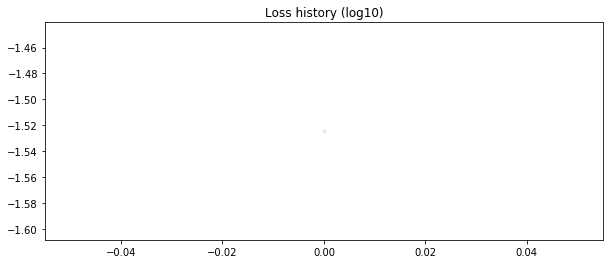

 step: 10, log10(loss): -1.525

In [29]:
model.train()

for i in range(10):
    x0 = np.repeat(seed[None, ...], BATCH_SIZE, 0)
    x0 = torch.Tensor(x0)
    optimizer.zero_grad()

    output = model(x0, 2, 3)
    loss_objective = loss_f(output)
    loss_objective.backward()
    scheduler.step()

    # DISPLAY
    lo_n = loss_objective.detach().numpy()
    o_n = output.detach().numpy()
    x0_n = x0.detach().numpy()
    
    step_i = len(loss_log)
    loss_log.append(lo_n)
    
    # if step_i%10 == 0:
    #     generate_pool_figures(pool, step_i)
    if step_i%100 == 0:
        clear_output()
        # visualize_batch(x0_n, o_n, step_i)
        plot_loss(loss_log)
        # export_model(ca, 'train_log/%04d'%step_i)

    print('\r step: %d, log10(loss): %.3f'%(len(loss_log), np.log10(lo_n)), end='')